# Project 2: Spam/Ham Classification
## By: Justin Chen

Goal: create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails.

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). The training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

The following cells to load the data into DataFrames.

The `train` DataFrame contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails.

In [5]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Downloading, this may take a few minutes.
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Downloading, this may take a few minutes.
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Some EDA

In [7]:
# Check for missing values
original_training_data = original_training_data.fillna(value={"id":0, "subject":"", "email":"", "spam":0})

# Examine structure of data/entries within the dataset
first_ham = original_training_data[original_training_data['spam'] == 0]['email'].iloc[0]
first_spam = original_training_data[original_training_data['spam'] == 1]['email'].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



**I notice that the spam email has HTML tags surrounding the text of the email which the ham email does not, suggesting that spam emails may be able to be differentiated by the presence of HTML heading/body formatting, or other graphics. This makes sense as spam email is often characterized by images, ads, and designs to entice the reciever to the subject of the email.**

### Training-Test Split

In [17]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

### Basic Feature Engineering

The function  `words_in_texts` takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

In [18]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for text in texts:
        row = []
        for word in words:
            if word in text:
                row.append(1)
            else:
                row.append(0)
        indicator_array.append(row)
    return np.array(indicator_array)

### Some More EDA

Visualize a set of {5} words with respect to proportion in Ham vs. Spam emails.

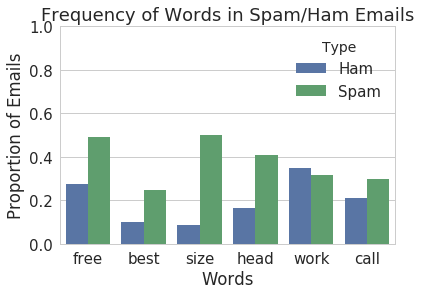

In [19]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts

words = ['free', 'best', 'size', 'head', 'work', 'call']

ham = words_in_texts(words, train["email"][train["spam"]==1])
spam = words_in_texts(words, train["email"][train["spam"]==0])

both = pd.DataFrame()
both["Words"] =  pd.Series(2 * words)
both["Proportion of Emails"] = [sum(x) / len(x) for x in spam.T] + [sum(x) / len(x) for x in ham.T]
both["Type"] = pd.Series(["Ham","Ham","Ham","Ham","Ham","Ham","Spam","Spam","Spam","Spam","Spam","Spam"])

#PLOTTING
sns.barplot(data=both,x="Words",y="Proportion of Emails",hue="Type")
plt.ylim(0,1.0)
plt.title('Frequency of Words in Spam/Ham Emails');

A conditional distribution plot comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set:

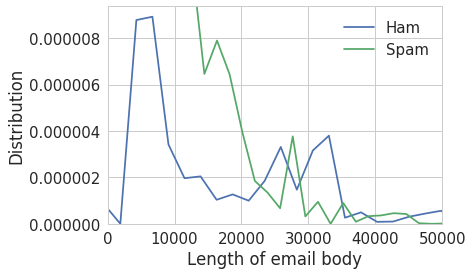

In [22]:
s = train[train['spam'] == 1]
h = train[train['spam'] == 0]

spamLen = [len(x) for x in s['email']]
hamLen = [len(x) for x in h['email']]

sns.distplot(hamLen, hist=False, label='Ham')
sns.distplot(spamLen, hist=False, label='Spam')
plt.xlim(0, 50000)
plt.xlabel('Length of email body')
plt.ylabel('Distribution')
plt.legend();

### Model Time

In [32]:
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from IPython.display import display, Markdown
import re

In [35]:
# For Visualizations later
train['email'] = train['email'].str.replace(r'[\"@\[\]{}\+$#\s,\.!?():=_-]+', ' ')
train = train.fillna({'index':0, 'subject':' ', 'email':' '})
train['html?'] = train['email'].str.contains('[<][/]?[azAz]*[>]')
train['url?'] = train['email'].str.contains('url{1}')
train['re?'] = train['subject'].str.contains('Re:')
train['tag?'] = train['subject'].str.contains('\[*\]*')
train['punc'] = len(train['email'].str.findall(r'\?!,\[\]()'))

**I noticed earlier that Spam emails tend to have HTML tags, so now we explore histograms for HTML tags**

/srv/app/venv/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


**It seems that HTML tags indeed can help our classifier as a feature.**

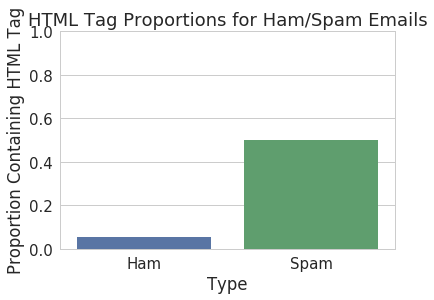

In [33]:
#EXPLORING EMAIL LENGTH AS A FEATURE
display(Markdown('**I noticed earlier that Spam emails tend to have HTML tags, so now we explore histograms for HTML tags**'))
train['html?'] = train['email'].str.contains('[<][/]?[azAz]*[>]')
ham = train[train['spam'] == 0]
ham_html = ham.groupby('html?').count().iloc[1][0] / len(ham)
spam = train[train['spam'] == 1]
spam_html = spam.groupby('html?').count().iloc[1][0] / len(spam)
html_df = pd.DataFrame()
html_df['Proportion Containing HTML Tag'] = pd.Series([ham_html, spam_html])
html_df['Proportion Not Containing HTML Tag'] = pd.Series([1 - ham_html, 1 - spam_html])
html_df['Type'] = pd.Series(['Ham', 'Spam'])
sns.barplot(x=html_df['Type'], y=html_df['Proportion Containing HTML Tag'])
plt.title('HTML Tag Proportions for Ham/Spam Emails')
plt.ylim(0.0, 1.0);

display(Markdown('**It seems that HTML tags indeed can help our classifier as a feature.**'))

**It seems that the presence of URLs indeed can help our classifier as a feature.**

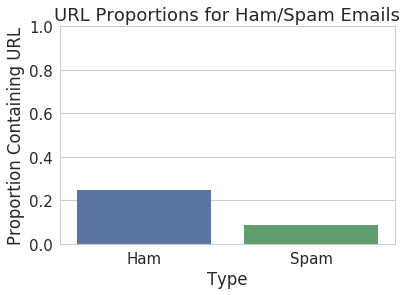

In [34]:
train['url?'] = train['email'].str.contains('url{1}')
ham = train[train['spam'] == 0]
spam = train[train['spam'] == 1]
ham_url = ham.groupby('url?').count().iloc[1][0] / len(ham)
spam_url = spam.groupby('url?').count().iloc[1][0] / len(spam)
url_df = pd.DataFrame()
url_df['Proportion Containing URL'] = pd.Series([ham_url, spam_url])
url_df['Proportion Not Containing URL'] = pd.Series([1 - ham_url, 1 - spam_url])
url_df['Type'] = pd.Series(['Ham', 'Spam'])
sns.barplot(x=url_df['Type'], y=url_df['Proportion Containing URL'])
plt.title('URL Proportions for Ham/Spam Emails')
plt.ylim(0.0, 1.0);
display(Markdown('**It seems that the presence of URLs indeed can help our classifier as a feature.**'))

**As we can see, the distributions are roughly the same as they are both significantly right skewed, and thus we can conclude that email length would not be a great feature to include in our model.**

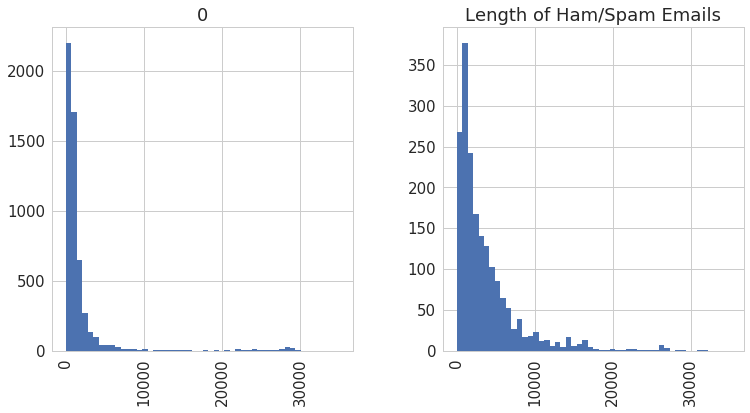

In [36]:
train['length'] = train['email'].map(lambda x: len(x))
train.hist(column='length', by='spam', bins=50, range=[0,35000], figsize=(12, 6))
plt.title('Length of Ham/Spam Emails');
display(Markdown('**As we can see, the distributions are roughly the same as they are both significantly right skewed, and thus we can conclude that email length would not be a great feature to include in our model.**'))

In [25]:
# Data Cleaning
def clean(data):
    data['email'] = data['email'].str.replace(r'[\"@\[\]{}\+$#\s,\.!?():=_-]+', ' ')
    data = data.fillna({'index':0, 'subject':' ', 'email':' '})
    return data

In [26]:
# Set of words to use as features, found through visualization in previous sections
words = ['free', 'offer', 'please', 'money', 'size', 'business', 'font', 'face', '2002', '20']

In [27]:
def xMatrix(words, data):
    data = clean(data)
    data['html?'] = data['email'].str.contains('[<][/]?[azAz]*[>]')
    data['url?'] = data['email'].str.contains('url{1}')
    data['re?'] = data['subject'].str.contains('Re:')
    data['tag?'] = data['subject'].str.contains('\[*\]*')
    data['punc'] = len(data['email'].str.findall(r'\?!,\[\]()'))
    indicator_array = []
    for index, email in data.iterrows():
        row = []
        
        #KEYWORD 
        for word in words:
            if word in email['email']:
                row.append(1)
            else:
                row.append(0)
        #HTML
        if email['html?']:
            row.append(1)
        else:
            row.append(0)
        #URL
        if email['url?']:
            row.append(1)
        else:
            row.append(0)
        #REPLY
        if email['re?']:
            row.append(1)
        else:
            row.append(0)
        #SUBJECT TAG
        if email['tag?']:
            row.append(1)
        else:
            row.append(0)
        #NUMBER CHARS UPPERCASE IN SUBJECT
        upper = int(sum([1 for char in email['subject'] if char.isupper()]))
        row.append(upper)
            
        indicator_array.append(row)
        
    return np.array(indicator_array)

In [28]:
X = xMatrix(words, train)
Y = train["spam"].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=52)

In [29]:
model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = np.count_nonzero(model.predict(X_train) == Y_train) / len(Y_train)
print("Training Accuracy: ", training_accuracy)


Training Accuracy:  0.9101497504159733
0.9101796407185628


In [30]:
print("Test Accuracy: ", np.count_nonzero(model.predict(X_test) == Y_test) / len(Y_test))

Test Accuracy:  0.9101796407185628


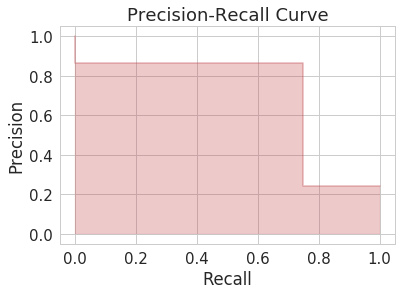

In [37]:
from sklearn.metrics import precision_recall_curve

precision, recall, x = precision_recall_curve(Y_test, model.predict(X_test))
plt.step(recall, precision, alpha=0.3, where='post', color='r')
plt.fill_between(recall, precision, alpha=0.3, step='post', color='r')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision');

In [38]:
test_predictions = model.predict(xMatrix(words, test))

In [39]:
from datetime import datetime

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('Now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2019-05-18T11:53:40.csv.
Now upload this CSV file to Kaggle for scoring.


### Final Note: this classifier achieved ~93-94% accuracy on Kaggle's test set.